In [1]:
import pandas as pd
import pickle
import string
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import rtree

In [19]:
#Open dataframe of all tweets
with open('insert your path to tweet data', "rb") as f:
    tweets = pickle.load(f)

In [ ]:
#Create a dataframe of users with geocoordinates
latitude = tweets["tweet_latitude"]
longitude = tweets["tweet_longitude"]
ID = tweets["user_id"]
users = pd.DataFrame(list(zip(ID, latitude, longitude)), columns =["ID", "Latitude", "Longitude"]) 

In [23]:
#Turn geocoordinates to numerics, create datasetts for lat and long, take the mean of lat and long for each user, and merge dataframe back together
users = users.dropna()
users["Latitude"] = pd.to_numeric(users["Latitude"])
users["Longitude"] = pd.to_numeric(users["Longitude"])
latitude = users[["ID", "Latitude"]]
latitude = latitude.groupby(["ID"]).agg(lambda x: pd.Series.mean(x)[0])
longitude = users[["ID", "Longitude"]]
longitude = longitude.groupby(["ID"]).agg(lambda x: pd.Series.mean(x)[0])
locations = pd.merge(latitude, longitude, left_on="ID", right_on="ID")

In [37]:
#Turn dataframe into a geopandas dataframe
gdf = gpd.GeoDataFrame(locations, geometry=gpd.points_from_xy(locations.Longitude, locations.Latitude))

In [ ]:
#Plot mean location of users with geocoordinates on world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black', figsize = (15,10))
base.set_title('Mode Location of Geocoordinated Users (N=35,948)', fontsize = 16, pad=20)
gdf.plot(ax=base, marker='o', color='blue', markersize=1)

#plt.savefig("new_figs/Average Location of Users Worldwide.pdf", dpi=300, bbox_inches ="tight", transparent=True)

In [15]:
#Load pakistan shapefile and convert to geopandas dataframe with only columns needed
locations = gpd.read_file('PAK_adm3.shp')
locations = gpd.GeoDataFrame(locations, geometry=locations.geometry)
locations = locations[["NAME_1", "NAME_2", "NAME_3", "geometry"]]

In [51]:
#Set coordinate reference system on location data
data = gdf.copy()
data = data.reset_index()
locations.crs = data.crs

In [29]:
# Merge location data with shapefile data
merged = gpd.sjoin(locations, data)

In [57]:
#Create dataframe to plot locations of all users
plot = merged[["NAME_3"]]
plot["count"] = 1
plot = plot.groupby(["NAME_3"]).sum()
plot = plot.merge(locations, how='left', left_on="NAME_3", right_on="NAME_3")
data = gpd.GeoDataFrame(plot, geometry=plot.geometry)

/home/dval/.conda/envs/symbolic/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


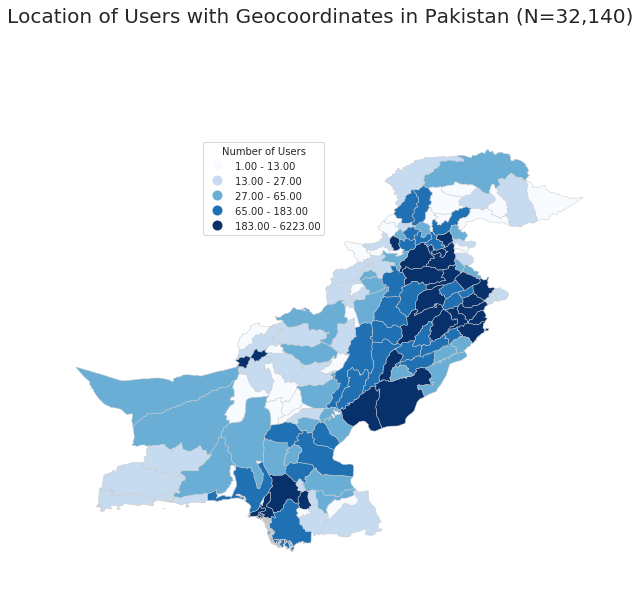

In [81]:
#Map locations of all users
with sns.axes_style("white"):
    sns.set_style("ticks")
    
    fig,ax = plt.subplots(figsize=(10,10))

    data_to_plot=data[['count','geometry']].copy()

    fig.suptitle('Location of Users with Geocoordinates in Pakistan (N=32,140)', fontsize = 20)
    
    data_to_plot.plot(
    'count',
    scheme='Quantiles',
    linewidth=0.5, 
    k=5,
    ax=ax, 
    cmap='Blues',
    edgecolor='0.8',
    legend=True,
    legend_kwds={
    'frameon': True, 
    'title': 'Number of Users',
    'loc': 'lower right',
    'bbox_to_anchor':(0.5, 0.75), 
    'frameon':'False',
    })
    ax.axis('off')
    
    plt.savefig("new_figs/Geocoordinated Users in Pakistan.pdf", dpi=300, bbox_inches ="tight", transparent = True)


In [83]:
#Save dataframe with named geolocations of users with geocoordinates
with open("geolocated_users.pickle", "wb") as f:
    pickle.dump(merged, f)